# Applied Probabilities and Randomized Algorithms: Balls Into Bins Simulations
Alviona Mancho | p3200098@aueb.gr

## Preliminaries

In [4]:
import random
import math
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [12]:
def print_message(prob_str, expected_val, actual_val):
    print("Expected {0}={1:.5f}\nActual {0}={2:.5f}\n".format(prob_str, expected_val, actual_val))

#### Function for the estimated probability of an event given a sample

In [5]:
def prob_event(sample, event):
    """Returns the estimated probability of event A in a sample, where A is a set of elementary events
    >>> sample = [1,2,4,2,2,3,5,3,6,1]
    >>> prob_event(sample, {2,3})
    0.5
    """
    size = len(sample)
    count = Counter(sample)
    count_event = sum(value for key, value in count.items() if key in event)
    prob_event = count_event/size
    return prob_event

#### Function for the estimated conditional expected value given a sample and a condition (event)

In [6]:
def cond_expected_value(sample, event):
    """Returns the estimated conditional expected value given a sample and the condition (event). If the event given is the empty set {}, then it returns the estimated expected value
    >>> sample = [1,2,3,4,5,6]
    >>> cond_expected_value(sample, {})
    3.5
    """
    size = len(sample)
    if(len(event) == 0):
        p_event = 1
    else:
        p_event = prob_event(sample, event)
    count = Counter(sample)
    
    cond_expected_val = sum(key*(value/size)/p_event for key, value in count.items() if len(event)==0 or key in event)
    return cond_expected_val

## Birthday Paradox

Assume that $m$ people are in the same room, and their birthdays are independent and uniformly distributed throughout the year.
We will record the number of pairs that share the same birthday. Specifically, for $m=20,30,40$ we will execute this process for 200 consecutive iterations and estimate the probability of having at least one pair with the same birthday, as well as the average count of such pairs. Lastly, we will compare our results with the theoretically predicted ones:

For a given $m$:

- $Pr(\textit{\# of pairs with the same birthday} >= 1) = 1 - Pr(\textit{\# of pairs with the same birthday} = 0)$ 
$$= 1 - \frac{365}{365}*\frac{364}{365}*...*\frac{365-m+1}{365} = 1 - \frac{365!}{365^m * (365-m)!}$$ 

- If $X=\textit{\# of pairs with the same birthday}$ then:

    $E(X) = \sum_{(i,j)}{E(X_{(i,j)})} = \sum_{(i,j)}{\frac{1}{365}} = \binom{m}{2} * \frac{1}{365} = \frac{m*(m-1)}{2*365}$ 


In [17]:
def generate_birthdays(num_people):
    """Generates random birthdays for the given number of people. Returns a list of integers in the interval [1,365]"""
    return [random.randint(1, 365) for _ in range(num_people)]

In [19]:
M = [20,30,40]
iters = 200

for m in M:
    num_pairs_same_birthday = [0]*iters
    for i in range(iters):
        birthdays = generate_birthdays(m)

        for first in range(len(birthdays)):
            for second in range(first+1, len(birthdays)):
                if(birthdays[first]==birthdays[second]):
                    num_pairs_same_birthday[i] += 1

    print("M = {0} people".format(m))
    prob_same_birthday = sum(pair_count >= 1 for pair_count in num_pairs_same_birthday)/iters
    print_message('Pr(# of pairs with the same birthday >= 1)', 1-math.factorial(365)/(365**m*math.factorial(365-m)), prob_same_birthday)
    print_message('E(# of pairs that share the same birthday)', m*(m-1)/(2*365), cond_expected_value(num_pairs_same_birthday, {}))
    print()
            

M = 20 people
Expected Pr(# of pairs with the same birthday >= 1)=0.41144
Actual Pr(# of pairs with the same birthday >= 1)=0.40500

Expected E(# of pairs that share the same birthday)=0.52055
Actual E(# of pairs that share the same birthday)=0.52000


M = 30 people
Expected Pr(# of pairs with the same birthday >= 1)=0.70632
Actual Pr(# of pairs with the same birthday >= 1)=0.72500

Expected E(# of pairs that share the same birthday)=1.19178
Actual E(# of pairs that share the same birthday)=1.23000


M = 40 people
Expected Pr(# of pairs with the same birthday >= 1)=0.89123
Actual Pr(# of pairs with the same birthday >= 1)=0.85500

Expected E(# of pairs that share the same birthday)=2.13699
Actual E(# of pairs that share the same birthday)=2.06000




Observations:
1. All results are close enough to the theoretically predicted ones, as expected. In case we increased the number of iterations (which is currently 200) we would observe even greater convergence. 

2. As $m$ increases, the probability $Pr(\textit{\# of pairs with the same birthday} >= 1)$ increases. We can conclude that for some $20 < m < 30$ this probability becomes $\approx 0.5$. It is known from theory that the least number of people that need to be in a room for this probability to be at least $0.5$ is $23$.

3. As $m$ increases, the expected value $E(X)$ of the number of pairs with the same birthday increases as well. We can conclude that for some $20 < m < 30$ this expected value becomes $\approx 1$. It is known from theory that the least number of people that need to be in a room for this expected value to be at least $1$ is $28$.

These numbers ($23$ or $28$, depending on the metric) are much smaller than what would someone anticipate, which is why this problem is called "The Birthday Paradox".

## Balls Into Bins

The balls into bins (or balanced allocations) problem is a classic problem in probability theory that has many applications in computer science. The problem involves $m$ balls and $n$ boxes (or "bins"). Each time, a single ball is placed into one of the bins.

[Wikipedia - Balls Into Bins](https://en.wikipedia.org/wiki/Balls_into_bins_problem)

### Definition

In [13]:
def balls_and_bins(bins, balls, iters, reduced_randomization = False):
    def one_random_bin(bins):
        rand_bin = random.randint(0, bins-1)
        return rand_bin
    
    def two_random_bins(bins):
        random_bins = random.sample(range(0, bins), 2)
        rand_bin_1 = random_bins[0]
        rand_bin_2 = random_bins[1]

        if balls_in_bins[rand_bin_1] < balls_in_bins[rand_bin_2]:
            return rand_bin_1
        elif balls_in_bins[rand_bin_2] < balls_in_bins[rand_bin_1]:
            return rand_bin_2
        else:
            if random.random() < 0.5:
                return rand_bin_1
            else:
                return rand_bin_2

    # Determine the way to choose a bin each time (one random bin or two random bins)
    choose_bin = one_random_bin
    if reduced_randomization:
        choose_bin = two_random_bins

    empty = list()
    two_or_more_balls = list()
    max_balls = list()

    for iter in range(iters):
        balls_in_bins = [0]*bins
        for ball in range(balls):
            rand_bin = choose_bin(bins)
            balls_in_bins[rand_bin] += 1

        num_empty = sum(balls == 0 for balls in balls_in_bins)
        num_two_or_more_balls = sum(balls >= 2 for balls in balls_in_bins)
        num_max_balls = max(balls_in_bins)

        if(iter<10):
            # Show statistics per iteration
            print("Iteration", iter+1)
            print("% of empty bins", num_empty/bins)
            print("% of bins with 2 or more balls", num_two_or_more_balls/bins)
            print("Maximum number of balls ", num_max_balls)
            print()

        # Store the number of empty bins, the number of bins with 2 or more balls and the maximum number of balls that fell into a bin,
        # to be able to calculate the mean for each one of them after the last iteration
        empty.append(num_empty)
        two_or_more_balls.append(num_two_or_more_balls)
        max_balls.append(num_max_balls)

    return empty, two_or_more_balls, max_balls

### Simulation for when each ball is placed in a randomly selected bin

Let's assume that we have $n=100$ bins and an equal number $m=100$ of balls, each of which is placed in a randomly selected bin. 

a. We will simulate the process of successive placement of all balls in bins. We will execute 200 consecutive repetitions of this process and estimate, in each of them:

- the percentage of bins remaining empty at the end (i.e., not selected by any ball),
- the percentage of bins containing 2 or more balls, and
- the maximum number of balls in a bin.

b. Then, for each of these measures, we will estimate the mean value from the 200 repetitions and compare our results with the theoretically expected values. Note that we will estimate the mean for the absolute numbers but the percentages can be easily obtained by dividing by the number of iterations.

- $Ε(\textit{number of bins that remained empty}) = n * Pr(\textit{empty bin}) = n*(1-\frac{1}{n})^m$
    - Why? Let $X_i = \begin{cases}
      1,\; if\; bin_i\; is\; empty \\
      0,\; otherwise
      \end{cases}$. That is, $X_i$~$Bernoulli(p)$, where $p=(1-\frac{1}{n})^m$

      Then $E(X) = E(\sum_{i=1}^n{X_i}) = \sum_{i=1}^n{E(X_i)} = \sum_{i=1}^n{p} = n*p$
        

- $E(\textit{number of bins with} \geq \textit{2 balls}) = n * (1-Pr(\textit{bin with} \leq \textit{1 balls})) =  n * (1-Pr(\textit{empty bin}) - Pr(\textit{bin with 1 ball})) = n * (1- (1-\frac{1}{n})^m - n*\frac{1}{n}*(1-\frac{1}{n})^{m-1}) = n * (1- (1-\frac{1}{n})^m - (1-\frac{1}{n})^{m-1})$


- $E(\textit{max load}) = \frac{ln(n)}{lnln(n)} + \mathcal{O}(1)$


c. Especially for the maximum number of balls in a bin, we will, also, observe the range of values within which it is likely to vary, and compare this result with the theoretically expected one:

- It is known that $Pr(bin_i \geq k\; balls) \leq (\frac{e}{k})^k$ (using the Chernoff bound we can obtain this upper bound). Hence, $Pr(max \geq k\; balls) \leq \sum_{i=1}^n{Pr(bin_i \geq k\; balls)} \leq n*(\frac{e}{k})^k$ (using the Union bound and the previous result). 
If we want to make this probability equal $\frac{1}{n}$, which is small enough, we should take a $k$ s.t. $(\frac{e}{k})^k = \frac{1}{n^2} \Rightarrow ... \Rightarrow k=\frac{3ln(n)}{ln(ln(n))}$.

  That is, $Pr(max \geq \frac{3ln(n)}{lnln(n)}\; balls) \leq \frac{1}{n} \Rightarrow Pr(max < \frac{3ln(n)}{lnln(n)}\; balls) \geq 1- \frac{1}{n}$

- If $X=\textit{\# of balls in a bin}$ then $E(X)=\frac{m}{n}$. That is, $\textit{max load}$ is at least $\frac{m}{n}\; balls$

In [14]:
n = 100 # bins
m = 100 # balls

iters = 200

# Conduct the simulation
empty, two_or_more_balls, max_balls = balls_and_bins(n, m, iters)

# Calculate the means
print_message("E(number of bins that remained empty)", n*(1-1/n)**m, cond_expected_value(empty, {}))
print_message("E(number of bins with >=2 balls)", n*(1-(1-1/n)**m-(1-1/n)**(m-1)), cond_expected_value(two_or_more_balls, {}))
print_message("E(maximum number of balls in a bin)", math.log(n)/math.log(math.log(n)), cond_expected_value(max_balls, {}))

print()
print("The maximum number of balls in a bin is more than {0:.3f} = lower".format(m/n))
print("The maximum number of balls in a bin is less than {0:.3f} = upper w.h.p.".format(3*math.log(n)/math.log(math.log(n))))
print("In this execution, the estimation for Pr(maximum number of balls in a bin < upper) was {0:.3f}".format(sum(x<3*math.log(n)/math.log(math.log(n)) for x in max_balls)/iters))

Iteration 1
% of empty bins 0.32
% of bins with 2 or more balls 0.26
Maximum number of balls  4

Iteration 2
% of empty bins 0.38
% of bins with 2 or more balls 0.28
Maximum number of balls  4

Iteration 3
% of empty bins 0.32
% of bins with 2 or more balls 0.23
Maximum number of balls  4

Iteration 4
% of empty bins 0.37
% of bins with 2 or more balls 0.28
Maximum number of balls  4

Iteration 5
% of empty bins 0.35
% of bins with 2 or more balls 0.27
Maximum number of balls  3

Iteration 6
% of empty bins 0.31
% of bins with 2 or more balls 0.22
Maximum number of balls  4

Iteration 7
% of empty bins 0.37
% of bins with 2 or more balls 0.28
Maximum number of balls  4

Iteration 8
% of empty bins 0.42
% of bins with 2 or more balls 0.28
Maximum number of balls  4

Iteration 9
% of empty bins 0.34
% of bins with 2 or more balls 0.22
Maximum number of balls  4

Iteration 10
% of empty bins 0.34
% of bins with 2 or more balls 0.27
Maximum number of balls  4

Expected E(number of bins tha

We can observe that the results are very close to the theoretically expected ones. Note that $E(\textit{max load}) = \frac{ln(n)}{lnln(n)} + \mathcal{O}(1)$ is an asymptotic result and not a closed-form formula, hence our result is not in exact accordance with the formula (but it is of the same order). Also, we can observe that the probability that the maximum number of balls in a bin is less than $\frac{3ln(n)}{ln(ln(n))} \approx 9.046$ is indeed estimated to be very high.

### Simulation for when each ball is placed in the bin with the fewest balls out of two randomly selected bins (partially random allocation)

Next, we modify the program so that the placement process occurs as follows: for each ball, two bins are randomly selected, and the ball is placed in the bin (from the two selected) that currently contains the fewest balls. If the two bins have an equal number of balls, then one of them is randomly chosen. We will compare the new results for the maximum number of balls in a bin with those obtained previously.

- In this case, $E(\textit{max load}) = \frac{lnln(n)}{ln2} + \mathcal{O}(1)$

In [15]:
n = 100 # bins
m = 100 # balls

iters = 200

# Conduct the simulation
empty, two_or_more_balls, max_balls = balls_and_bins(n, m, iters, reduced_randomization=True)

# Calculate the means
print("Actual E(number of bins that remained empty) = {0:.5f}".format(cond_expected_value(empty, {})))
print("Actual E(number of bins with >=2 balls) = {0:.5f}\n".format(cond_expected_value(two_or_more_balls, {})))
print_message("E(maximum number of balls in a bin)", math.log(math.log(n))/math.log(2), cond_expected_value(max_balls, {}))

Iteration 1
% of empty bins 0.21
% of bins with 2 or more balls 0.21
Maximum number of balls  2

Iteration 2
% of empty bins 0.21
% of bins with 2 or more balls 0.21
Maximum number of balls  2

Iteration 3
% of empty bins 0.25
% of bins with 2 or more balls 0.25
Maximum number of balls  2

Iteration 4
% of empty bins 0.21
% of bins with 2 or more balls 0.2
Maximum number of balls  3

Iteration 5
% of empty bins 0.26
% of bins with 2 or more balls 0.25
Maximum number of balls  3

Iteration 6
% of empty bins 0.23
% of bins with 2 or more balls 0.22
Maximum number of balls  3

Iteration 7
% of empty bins 0.27
% of bins with 2 or more balls 0.26
Maximum number of balls  3

Iteration 8
% of empty bins 0.21
% of bins with 2 or more balls 0.21
Maximum number of balls  2

Iteration 9
% of empty bins 0.3
% of bins with 2 or more balls 0.29
Maximum number of balls  3

Iteration 10
% of empty bins 0.19
% of bins with 2 or more balls 0.19
Maximum number of balls  2

Actual E(number of bins that re

Note that $E(\textit{max load}) = \frac{lnln(n)}{ln(2)} + \mathcal{O}(1)$ is an asymptotic result and not a closed-form formula, hence our result is not in exact accordance with the formula (but it is of the same order). In comparison to the previous case, we introduce a limitation on randomness. In the previous scenario, we randomly selected the bin where the next ball would be placed. Now, however, we randomly choose 2 bins and deterministically select the best option between them (i.e. the bin with the smallest load so far). This results in a significant improvement in the expected value for the maximum load in the partial allocation ($\frac{lnln(n)}{ln(2)} + \mathcal{O}(1)$), which is almost exponentially less than with a completely random allocation ($\frac{ln(n)}{lnln(n)} + \mathcal{O}(1)$)!

Moreover, we observe that both the mean number (and consequently, the percentage) of empty bins and the mean number of bins with at least 2 balls have decreased. This indicates a more balanced load than before, considering that the ideal balance is achieved when each bin contains exactly 1 ball (for $m=n$).

### Simulation for $m\approx3n*(log_2n)$ - Heavy loaded case

Let $n=100$ as before, and $m=4000\approx3n*(log_2n)$. We will run the simulation again.

In this case:
- $E(\textit{max load}) = \frac{m}{n} + \Theta(\sqrt{\frac{m*ln(n)}{n}})$
- $Pr(max < \frac{em}{n}\; balls) \geq 1- \frac{1}{n}$   (using Chernoff bound and union bound, proof details omitted here)

In [16]:
n = 100 # bins
m = 4000 # balls

iters = 200

# Conduct the simulation
empty, two_or_more_balls, max_balls = balls_and_bins(n, m, iters)

# Calculate the means
print_message("E(number of bins that remained empty)", n*(1-1/n)**m, cond_expected_value(empty, {}))
print_message("E(number of bins with >=2 balls)", n*(1-(1-1/n)**m-(1-1/n)**(m-1)), cond_expected_value(two_or_more_balls, {}))
print_message("E(maximum number of balls in a bin)", m/n+math.sqrt(m*math.log(n)/n), cond_expected_value(max_balls, {}))

print()
print("The maximum number of balls in a bin is more than {0:.3f} = lower".format(m/n))
print("The maximum number of balls in a bin is less than {0:.3f} = upper w.h.p.".format(math.e*m/n))
print("In this execution, the estimation for Pr(maximum number of balls in a bin < upper) was {0:.3f}".format(sum(x<math.e*m/n for x in max_balls)/iters))

Iteration 1
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  51

Iteration 2
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  54

Iteration 3
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  55

Iteration 4
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  57

Iteration 5
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  54

Iteration 6
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  58

Iteration 7
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  59

Iteration 8
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  56

Iteration 9
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  54

Iteration 10
% of empty bins 0.0
% of bins with 2 or more balls 1.0
Maximum number of balls  56

Expected E(number of bins that remained

Note that again $E(\textit{max load}) = \frac{m}{n} + \Theta(\sqrt{\frac{m*ln(n)}{n}})$ is an asymptotic result and not a closed-form formula.

We observe that the results are very close to the theoretically expected ones.

Moreover, no bins remained empty in the heavy loaded case simulation, and all bins got at least 2 balls, which was totally expected.

## Coupon Collector

We can view the problem of the coupon collector as follows: Let's assume that we have $n=100$ boxes (the types of coupons) and an unlimited number of balls (the 'attempts'), which are placed one by one in a randomly selected box each. We will simulate the process of successive ball placement in boxes, which stops when all boxes contain at least one ball (i.e. the collector has collected all types of coupons). 

We will execute 200 consecutive repetitions of this process and record, in each iteration, the number of 'attempts' required to achieve the above goal. Then, we will estimate the mean value of this and compare this result with the theoretically expected one:

For a given number $n$ of boxes/coupons types:
- If $X=\textit{\# of attempts}$, then it is known that $E(X) = n*(ln(n) + \gamma)$, where $\gamma$ is the Euler-Mascheroni constant.

Moreover,
- If $Y= \textit{\# of attempts till no bin is empty}$, then, by Chebyshev inequality, $Pr(|Y − E(Y)| \geq c) \leq \frac{c^2}{VAR(Y)}$
    - $VAR(Y) = n^2\frac{\pi^2}{6} - n(ln(n) + \gamma)$ (proof omitted here)
    - Therefore, for $c=(\lambda +\mathcal{O}(1))n$, we can obtain $Pr(|Y − E(Y)| \geq c) \leq \frac{c^2}{VAR(Y)} \leq ... \leq \frac{1}{\lambda}$

    This implies that the value of Y is highly concentrated around its mean!

In [471]:
def collect_coupons(coupons):
    # At first all boxes are empty/no coupons collected
    coupons_collected_per_type = [0]*coupons

    # While there are empty boxes/uncollected coupons, keep trying
    while any(element == 0 for element in coupons_collected_per_type):  
        rand_coupon = random.randint(0, coupons-1)
        coupons_collected_per_type[rand_coupon] += 1
        
    # Return the number of attempts
    return sum(coupons_collected_per_type)

Expected E(attempts)=518.23859 	 Actual E(attempts)=519.47000


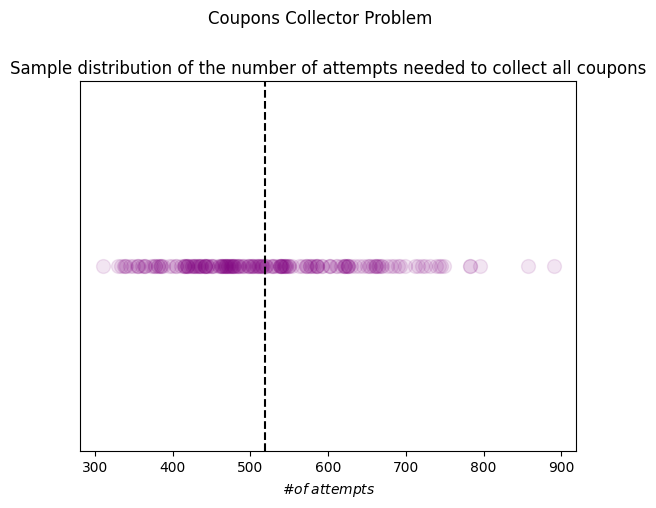

In [472]:
coupons = 100
iters = 200

attempts_list = list()
for iter in range(iters):
    attempts_list.append(collect_coupons(coupons))

print_message("E(attempts)",100*(math.log(100) + np.euler_gamma), cond_expected_value(attempts_list, {}))

#Plot a 1D scatterplot showing the sample distribution of the number of attempts
plt.plot(attempts_list, [0]*len(attempts_list), 'o', color='purple', alpha=0.1, ms='10')
plt.suptitle('Coupons Collector Problem', y=1.03)
plt.title(r'Sample distribution of the number of attempts needed to collect all coupons')
plt.xlabel(r'$\# of\; attempts$')
plt.ylim(-1,1)
plt.axvline(x=100*(math.log(100) + np.euler_gamma), color='black', linestyle='--')
plt.yticks([])

plt.show()

We can observe that the result is very close to the theoretically expected one. 

Moreover, the numbers of attempts are indeed highly concentrated around the expected value $\approx 518$ (dashed line above).